# Car Evaluation Using SVM Classification Models

## Introduction

Car evaluation plays a crucial role in the automotive industry. It is a key factor in purchasing decisions for consumers, who consider various aspects such as price, safety, performance, and maintenance costs. Similarly, car manufacturers and dealerships need to assess the quality and value of vehicles to inform their marketing and production strategies. Therefore, developing an effective car evaluation system is of great importance to both consumers and industry stakeholders.

## Project Objective

The objective of this project is to train and evaluate different types of **Support Vector Machine (SVM)** classification models to solve a multi-class classification problem. SVMs are well-suited for this task due to their ability to handle high-dimensional data and find optimal decision boundaries. By employing SVMs, we aim to accurately categorize cars into different evaluation classes based on their attributes. Additionally, we aim to explore the concept of ensemble learning and leverage its principles to combine the trained SVM models for improved classification performance.

## Dataset

The dataset used in this project is the **Car Evaluation dataset**, obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/19/car+evaluation). It consists of a collection of car instances, each characterized by various attributes such as buying price, maintenance cost, number of doors, safety features, and more. The dataset serves as a suitable resource for testing constructive induction and structure discovery methods. It provides us with a diverse set of car examples to train and evaluate our SVM-based classification model.

## Report Structure

In the following sections of this report, we will:

1. Discuss the mathematical formulation of the multi-class classification problem using SVMs.
2. Present our implementation details, including the code used to train and evaluate the SVM models.
3. Display and thoroughly discuss the results obtained from our experiments on the Car Evaluation dataset.

Finally, we will conclude our findings based on the Car Evaluation dataset and propose potential future directions for further exploration in the field of multi-class classification using SVMs and ensemble learning techniques.

# Mathematical Model

The mathematical model for a Support Vector Machine (SVM) is derived from the field of statistical learning theory. The SVM is a binary classification model that aims to find the optimal hyperplane that separates two classes of data points with the maximum margin.

## Decision Variables

The decision variables in an SVM are the weights $\mathbf{w}$ and bias $b$ that define the hyperplane, and the slack variables $\eta$ that allow for soft-margin classification.

## Constraints

The constraints in an SVM ensure that each data point is on the correct side of the hyperplane or within the margin. For a data point $\mathbf{x}_i$ with label $y_i$ in $\{-1, 1\}$, the constraints are:

$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \eta_i \quad \text{for all } i$$

and the slack variables are non-negative:

$$\eta_i \geq 0 \quad \text{for all } i$$

## Objective Function

The objective function in an SVM is a trade-off between maximizing the margin (minimizing $||\mathbf{w}||^2$) and minimizing the sum of the slack variables. The objective function is:

$$\min_{\mathbf{w}, b, \eta} \quad ||\mathbf{w}||^2 + \lambda \cdot \sum \eta_i$$

where $\lambda$ is a regularization parameter that controls the trade-off.

## Optimization Problem

The optimization problem for an SVM can be written in standard form as follows:

# Mathematical Model

The mathematical model for a Support Vector Machine (SVM) is derived from the field of statistical learning theory. The SVM is a binary classification model that aims to find the optimal hyperplane that separates two classes of data points with the maximum margin.

## Decision Variables

The decision variables in an SVM are the weights $\mathbf{w}$ and bias $b$ that define the hyperplane, and the slack variables $\eta$ that allow for soft-margin classification.

## Constraints

The constraints in an SVM ensure that each data point is on the correct side of the hyperplane or within the margin. For a data point $\mathbf{x}_i$ with label $y_i$ in $\{-1, 1\}$, the constraints are:

$$y_i(\mathbf{w}^T \mathbf{x}_i - b) \geq 1 - \eta_i \quad \text{for all } i$$

and the slack variables are non-negative:

$$\eta_i \geq 0 \quad \text{for all } i$$

## Objective Function

The objective function in an SVM is a trade-off between maximizing the margin (minimizing $||\mathbf{w}||^2$) and minimizing the sum of the slack variables. The objective function is:

$$\min_{\mathbf{w}, b, \eta} \quad ||\mathbf{w}||^2 + \lambda \cdot \sum \eta_i$$

where $\lambda$ is a regularization parameter that controls the trade-off.

## Optimization Problem

The optimization problem for an SVM can be written in standard form as follows:

$$  \min_{\mathbf{w}, b, \eta} \quad ||\mathbf{w}||^2 + \lambda \cdot \sum \eta_i$$    
$$s.t. \quad y_i(\mathbf{w}^T \mathbf{x}_i - b) \geq 1 - \eta_i \quad \text{for all } i$$
$$\eta_i \geq 0 \quad \text{for all } i$$

## Model Type

The SVM is a Quadratic Programming (QP) problem because it involves the minimization of a quadratic objective function subject to linear constraints.


## Dual Problem

The dual problem of an SVM involves maximizing a Lagrangian function with respect to Lagrange multipliers, subject to certain constraints. The dual formulation allows the use of kernel functions to implicitly map data into higher-dimensional spaces, enabling the SVM to handle non-linear classification. The dual problem is formulated as:

$$\max_{\alpha} \quad \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n y_i y_j \alpha_i \alpha_j K(\mathbf{x}_i, \mathbf{x}_j)$$    
$$s.t. \quad 0 \leq \alpha_i \leq C \quad \text{for all } i$$
$$\sum_{i=1}^n y_i \alpha_i = 0$$

where $\alpha_i$ are the Lagrange multipliers, and $K(\mathbf{x}_i, \mathbf{x}_j)$ is a kernel function.

# Solution

## Code Explanation

### Data Preprocessing

In this step, we load the car evaluation dataset and perform necessary preprocessing. This includes encoding categorical variables, and splitting the data into training and testing sets.

In [57]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [58]:
# Read the dataset from the file
data = pd.read_csv('car+evaluation/car.data', header=None)
data = pd.get_dummies(data)
data.iloc[:,:] = data.iloc[:,:].replace({False: -1, True: 1})
# Display the first few rows of the dataset
data.info()
data.iloc[:5,:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0_high   1728 non-null   int64
 1   0_low    1728 non-null   int64
 2   0_med    1728 non-null   int64
 3   0_vhigh  1728 non-null   int64
 4   1_high   1728 non-null   int64
 5   1_low    1728 non-null   int64
 6   1_med    1728 non-null   int64
 7   1_vhigh  1728 non-null   int64
 8   2_2      1728 non-null   int64
 9   2_3      1728 non-null   int64
 10  2_4      1728 non-null   int64
 11  2_5more  1728 non-null   int64
 12  3_2      1728 non-null   int64
 13  3_4      1728 non-null   int64
 14  3_more   1728 non-null   int64
 15  4_big    1728 non-null   int64
 16  4_med    1728 non-null   int64
 17  4_small  1728 non-null   int64
 18  5_high   1728 non-null   int64
 19  5_low    1728 non-null   int64
 20  5_med    1728 non-null   int64
 21  6_acc    1728 non-null   int64
 22  6_good   1728 non-null  

,0_high,0_low,0_med,0_vhigh,1_high,1_low,1_med,1_vhigh,2_2,2_3,...,4_big,4_med,4_small,5_high,5_low,5_med,6_acc,6_good,6_unacc,6_vgood
0,-1,-1,-1,1,-1,-1,-1,1,1,-1,...,-1,-1,1,-1,1,-1,-1,-1,1,-1
1,-1,-1,-1,1,-1,-1,-1,1,1,-1,...,-1,-1,1,-1,-1,1,-1,-1,1,-1
2,-1,-1,-1,1,-1,-1,-1,1,1,-1,...,-1,-1,1,1,-1,-1,-1,-1,1,-1
3,-1,-1,-1,1,-1,-1,-1,1,1,-1,...,-1,1,-1,-1,1,-1,-1,-1,1,-1
4,-1,-1,-1,1,-1,-1,-1,1,1,-1,...,-1,1,-1,-1,-1,1,-1,-1,1,-1


In [59]:
# The last 4 columns are the labels of target feature
feat_num = data.shape[1] - 4
columns = [i for i in range(feat_num)]

train_X, test_X, train_y, test_y = train_test_split(data.iloc[:, columns], data.iloc[:, 21], test_size=0.3)

# Create an instance of the StandardScaler
scaler = MinMaxScaler()

# Normalize the data
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

## Model Implementation

We implement the SVM model using CVX. The model is trained on the training data and then used to make predictions on the testing data.

## Dual problem

This code cell defines four different types of kernel functions that can be used in a Support Vector Machine (SVM) model:

1. **Gaussian Kernel**: This is a radial basis function kernel, also known as the RBF kernel. It is a popular choice in SVM classification. The `gaussian_kernel` function takes in two inputs, `x` and `y`, and a parameter `sigma`. It returns the Gaussian similarity of `x` and `y`, which decreases with distance and ranges between 0 (in the limit) and 1 (when `x` = `y`).

2. **Linear Kernel**: This is the simplest type of kernel function. The `linear_kernel` function takes in two inputs, `x` and `y`, and returns their dot product. This is equivalent to a linear classifier in the input space.

3. **Polynomial Kernel**: This kernel function generates similarity measures in the feature space over polynomials of the original variables, allowing for polynomial decision boundaries. The `polynomial_kernel` function takes in two inputs, `x` and `y`, and two parameters `c` and `d`. It returns the dot product of `x` and `y`, adds `c`, and raises the result to the power of `d`.

4. **Laplacian Kernel**: This is another radial basis function kernel, similar to the Gaussian kernel but with a sharper decrease in similarity with distance. The `laplacian_kernel` function takes in two inputs, `x` and `y`, and a parameter `sigma`. It returns the Laplacian similarity of `x` and `y`.

In [60]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))
def linear_kernel(x, y):
    return np.dot(x, y)
def polynomial_kernel(x, y, c=1, d=7):
    return (np.dot(x, y) + c) ** d
def laplacian_kernel(x, y, sigma=1):
    return np.exp(-np.linalg.norm(x - y) / sigma)

This Python function, `train_kernel_svm`, trains a Support Vector Machine (SVM) model using different kernel functions in dual problem. It takes in training and testing data, a regularization parameter, and a kernel type. The function computes the kernel matrix, defines and solves the optimization problem for the SVM, makes predictions on the test data, and calculates the model's accuracy.

In [61]:
def train_kernel_svm(X_train, y_train, X_test, y_test, C = 1, kernel='gaussian'):
    if kernel == 'gaussian':
        kernel_matrix = np.array([[gaussian_kernel(x, y) for y in train_X] for x in train_X])
    elif kernel == 'linear':
        kernel_matrix = np.array([[linear_kernel(x, y) for y in train_X] for x in train_X])
    elif kernel == 'polynomial':
        kernel_matrix = np.array([[polynomial_kernel(x, y) for y in train_X] for x in train_X])
    elif kernel == 'laplacian':
        kernel_matrix = np.array([[laplacian_kernel(x, y) for y in train_X] for x in train_X])
    alpha = cp.Variable((train_X.shape[0],1))
    outer_y = train_y.values.reshape((-1,1)) * train_y.values.reshape((-1,1)).T
    gram = outer_y * kernel_matrix
    objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(alpha, cp.psd_wrap(gram)))
    constraints = [0 <= alpha, alpha <= C, train_y.values @ alpha == 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver = cp.SCS)
    print("problem status: ",problem.status)
    test_kernel_matrix = np.array([[gaussian_kernel(x, y) for y in test_X] for x in train_X])
    predictions = np.sign(np.sum(train_y.values.reshape((-1,1)) * alpha.value * test_kernel_matrix, axis=0))
    accuracy = np.mean(predictions == test_y.values)
    print('Kernel: {}, Accuracy: {}'.format(kernel, accuracy))

## primal problem

Here is a helper function used to plot the data

In [62]:
def plot_history(history, title):
    # Plot the history, the x-axis is the gamma value, the y-axis is the accuracy
    # This paragraph compares the accuracy of the training set and the test set
    history = np.array(history)
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    
    # Filter the data for regularization type 1
    reg_type_1 = history[history[:, 0] == 1]
    axs.plot(reg_type_1[:, 1], reg_type_1[:, 3], marker='o', color='green', label='test accuracy (reg type 1)')
    axs.plot(reg_type_1[:, 1], reg_type_1[:, 2], marker='o', color='blue', label='train accuracy (reg type 1)')
    
    # Filter the data for regularization type 2
    reg_type_2 = history[history[:, 0] == 2]
    axs.plot(reg_type_2[:, 1], reg_type_2[:, 3], marker='x', color='green', label='test accuracy (reg type 2)')
    axs.plot(reg_type_2[:, 1], reg_type_2[:, 2], marker='x', color='blue', label='train accuracy (reg type 2)')
    
    axs.set_xlabel('gamma')
    axs.set_ylabel('accuracy')
    axs.legend()
    
    plt.title(title)
    plt.show()


In this cell we're training a simple linear SVM model to classify whether the class is unacceptable. (We merge other 3 classes)

In [63]:
# Train the SVM classifier with a soft margin
def train_linear_svm(X_train, y_train, X_test, y_test, gamma = 0.001, norm = 1):
    # m is the number of training examples
    m = X_train.shape[0]
    # n is the number of features
    n = X_train.shape[1]
    # Need to train k different classifiers
    k = y_train.shape[1]
    predict_train = np.zeros((k,m,1))
    predict_test = np.zeros((k,X_test.shape[0],1))
    for i in range(k):
        y = y_train[:,i].reshape((-1,1))
        w = cp.Variable((n,1))
        b = cp.Variable()
        eta = cp.Variable((m,1))
        norm_eta = cp.norm1(eta) if norm == 1 else cp.norm2(eta)
        const = np.ones((m,1))
        objective = cp.Minimize(cp.norm2(w) + gamma * norm_eta)
        constraints = [cp.multiply(y, X_train @ w - b) >= const - eta, eta >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        predict_train[i] = np.sign((X_train @ w.value - b.value * const))
        predict_test[i] = np.sign((X_test @ w.value - b.value * np.ones((X_test.shape[0],1))))
    predict_train = np.squeeze(predict_train.T)
    accuracy_train = np.mean(np.all(predict_train == y_train, axis=1))
    accuracy_train = round(accuracy_train, 3)
    predict_test = np.squeeze(predict_test.T)
    accuracy_test = np.mean(np.all(predict_test == y_test, axis=1))
    accuracy_test = round(accuracy_test, 3)

    return accuracy_train, accuracy_test

def train_best_simple_svm(data_path = 'car+evaluation/car.data', gama_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]):
    data = pd.read_csv(data_path, header=None)
    data = pd.get_dummies(data)
    # Change the false labels to -1 in last 4 columns
    data.iloc[:,:] = data.iloc[:,:].replace({False: -1, True: 1})
    train_ratio = 0.8
    X_train = data.iloc[:int(train_ratio * data.shape[0]),:-4].values
    y_train = data.iloc[:int(train_ratio * data.shape[0]),-4:].values
    X_test = data.iloc[int(train_ratio * data.shape[0]):,:-4].values
    y_test = data.iloc[int(train_ratio * data.shape[0]):,-4:].values
    norms = [1, 2]
    history = []
    for norm in norms:
        for gamma in gamma_list:
            accuracy_train, accuracy_test = train_linear_svm(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, gamma = gamma, norm = norm)
            history.append([norm, gamma, accuracy_train, accuracy_test])
    #for row in history:
    #    print('norm: {}, gamma: {}, train accuracy: {}, test accuracy: {}'.format(row[0], row[1], row[2], row[3]))
    # Find the best test accuracy row
    best_row = history[np.argmax(np.array(history)[:,-1])]
    print('best test accuracy: {:<10} training accuracy: {:<10} norm: {:<10} gamma: {:<10}'.format(best_row[3], best_row[2], best_row[0], best_row[1]))
    plot_history(history, 'simple SVM')

In this cell we're training multiple one-vs-one SVM models and use its majority vote to predict y. When it comes into a tie, choose the class with the smallest index.

In [64]:
def train_ovo_svm(X_train, X_test, y_train, y_test, gamma, eta_norm):
    # Number of training examples
    m = X_train.shape[0]
    # Number of features
    n = X_train.shape[1]
    # Number of classes
    k = 4
    
    # Initialize the predictions matrix
    train_predictions = np.zeros((m, 6))
    test_predictions = np.zeros((X_test.shape[0], 6))
    
    # Train k*(k-1)/2 SVM models
    model_index = 0
    for i in range(k):
        for j in range(i+1, k):
            # Select the samples for the current pair of classes
            X_train_pair = X_train[np.logical_or(y_train == i, y_train == j)]
            y_train_pair = y_train[np.logical_or(y_train == i, y_train == j)]
            y_train_pair = np.where(y_train_pair == i, -1, 1).reshape((-1,1))
            
            X_test_pair = X_test[np.logical_or(y_test == i, y_test == j)]
            y_test_pair = y_test[np.logical_or(y_test == i, y_test == j)]
            y_test_pair = np.where(y_test_pair == i, -1, 1).reshape((-1,1))
            if(X_train_pair.shape[0] == 0):
                continue
            # Variables
            w = cp.Variable((n,1))
            b = cp.Variable()
            eta = cp.Variable((X_train_pair.shape[0],1))
            
            # Constraints
            constraints = [cp.multiply(y_train_pair, X_train_pair @ w - b) >= 1 - eta, eta >= 0]
            
            # Objective function
            objective = cp.Minimize(cp.norm2(w) + gamma * cp.norm(eta, eta_norm))
            
            # Problem definition
            problem = cp.Problem(objective, constraints)
            
            # Solve the problem
            problem.solve()
            
            # Get the optimal values
            w_opt = w.value.reshape((-1,1))
            b_opt = b.value
            
            # Calculate the predictions for training and test data
            train_predictions[:, model_index] = np.sign(X_train @ w_opt - b_opt).reshape((-1,))
            test_predictions[:, model_index] = np.sign(X_test @ w_opt - b_opt).reshape((-1,))
            # If the prediction is negative, the class is i, otherwise it is j
            # Change the prediction value into i or j
            train_predictions[:, model_index] = np.where(train_predictions[:, model_index] == -1, i, j)
            test_predictions[:, model_index] = np.where(test_predictions[:, model_index] == -1, i, j)
            
            
            model_index += 1
    
    # Calculate the final predictions by majority voting
    # If there is a tie, choose the class with the smallest index
    train_final_predictions = np.zeros((m,))
    test_final_predictions = np.zeros((X_test.shape[0],))
    for i in range(m):
        train_final_predictions[i] = np.argmax(np.bincount(train_predictions[i,:].astype('int')))
    for i in range(X_test.shape[0]):
        test_final_predictions[i] = np.argmax(np.bincount(test_predictions[i,:].astype('int')))
    
    # Calculate the accuracies
    train_accuracy = np.mean(train_final_predictions == y_train)
    test_accuracy = np.mean(test_final_predictions == y_test)
    train_accuracy = round(train_accuracy, 3)
    test_accuracy = round(test_accuracy, 3)
    
    return train_accuracy, test_accuracy

def train_best_ovo_svm(data_path = 'car+evaluation/car.data', gamma_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]):
    data = pd.read_csv(data_path, header=None)
    # Change each string value to a unique integer
    for col in data.columns:
        data[col] = data[col].astype('category').cat.codes
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    
    train_ratio = 0.8
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio) 
    eta_norms = [1, 2]
    
    history = []
    
    for gamma in gamma_list:
        for eta_norm in eta_norms:
            train_accuracy, test_accuracy = train_ovo_svm(X_train, X_test, y_train, y_test, gamma, eta_norm)
            history.append([eta_norm, gamma, train_accuracy, test_accuracy])
    #for row in history:
    #   print('norm: {}, gamma: {}, train accuracy: {}, test accuracy: {}'.format(row[0], row[1], row[2], row[3]))
    # Find the best test accuracy row
    best_row = history[np.argmax(np.array(history)[:,-1])]
    print('best test accuracy: {:<10} training accuracy: {:<10} norm: {:<10} gamma: {:<10}'.format(best_row[3], best_row[2], best_row[0], best_row[1]))
    plot_history(history=history, title='One vs One SVM')


In this cell we're training multiple one-vs-all SVM models and use the model with highest confidence as the final prediction

In [65]:
# Train the SVM classifier with a soft margin, multiple one-vs-all classifiers
def train_ova_svm(X_train, y_train, X_test, y_test, gamma = 0.001, norm = 1):
    # m is the number of training examples
    m = X_train.shape[0]
    # n is the number of features
    n = X_train.shape[1]
    # k is the number of possible values of y
    k = np.unique(y_train).shape[0]
    # Need to train k different classifiers, one for each value of y
    predict_train = np.zeros((k,m,1))
    predict_test = np.zeros((k,X_test.shape[0],1))
    for i in range(k):
        class_i = np.unique(y_train)[i]
        y = np.where(y_train == class_i, -1, 1).reshape((-1,1))
        w = cp.Variable((n,1))
        b = cp.Variable()
        eta = cp.Variable((m,1))
        norm_eta = cp.norm1(eta) if norm == 1 else cp.norm2(eta)
        const = np.ones((m,1))
        objective = cp.Minimize(cp.norm2(w) + gamma * norm_eta)
        constraints = [cp.multiply(y, X_train @ w - b) >= const - eta, eta >= 0]
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        predict_train[i] = X_train @ w.value - b.value * const
        predict_test[i] = X_test @ w.value - b.value * np.ones((X_test.shape[0],1))
    # For each row of pretiction, choose the class with the highest confidence
    predict_train = np.squeeze(predict_train.T)
    predict_train = np.argmax(predict_train, axis=1, keepdims=True)
    accuracy_train = np.mean(np.all(predict_train == y_train, axis=1))
    accuracy_train = round(accuracy_train, 3)
    predict_test = np.squeeze(predict_test.T)
    predict_test = np.argmax(predict_test, axis=1, keepdims=True)
    accuracy_test = np.mean(np.all(predict_test == y_test, axis=1))
    accuracy_test = round(accuracy_test, 3)
    return accuracy_train, accuracy_test

def train_best_ova_svm(data_path = 'car+evaluation/car.data', gamma_list = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]):
    data = pd.read_csv(data_path, header=None)
    train_ratio = 0.8
    for col in data.columns:
        data[col] = data[col].astype('category').cat.codes
    X_train = data.iloc[:int(train_ratio * data.shape[0]),:-1].values
    y_train = data.iloc[:int(train_ratio * data.shape[0]),-1].values.reshape((-1,1))
    X_test = data.iloc[int(train_ratio * data.shape[0]):,:-1].values
    y_test = data.iloc[int(train_ratio * data.shape[0]):,-1].values.reshape((-1,1))
    norms = [1, 2]
    history = []
    for norm in norms:
        for gamma in gamma_list:
            accuracy_train, accuracy_test = train_ova_svm(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, gamma = gamma, norm = norm)
            history.append([norm, gamma, accuracy_train, accuracy_test])
    # Find the best test accuracy row
    best_row = history[np.argmax(np.array(history)[:,-1])]
    print('best test accuracy: {:<10} training accuracy: {:<10} norm: {:<10} gamma: {:<10}'.format(best_row[3], best_row[2], best_row[0], best_row[1]))
    plot_history(history=history, title='One-vs-all SVM')

best test accuracy: 0.734      training accuracy: 0.884      norm: 1          gamma: 0.53      


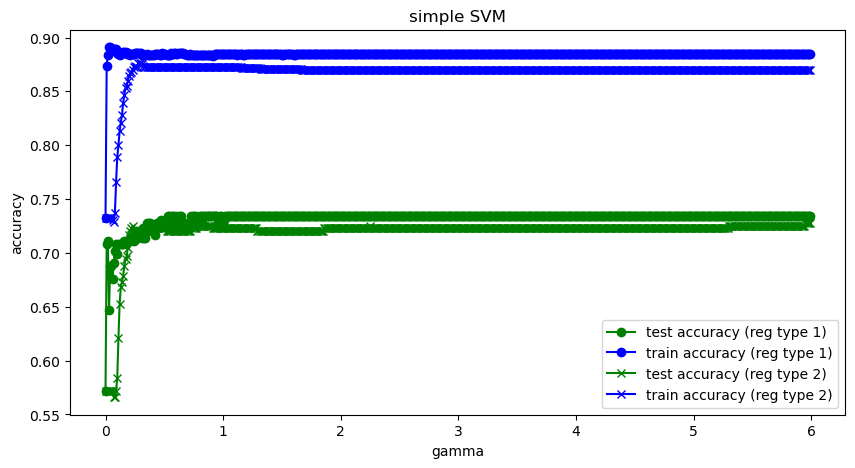

best test accuracy: 0.205      training accuracy: 0.103      norm: 1          gamma: 0.04      


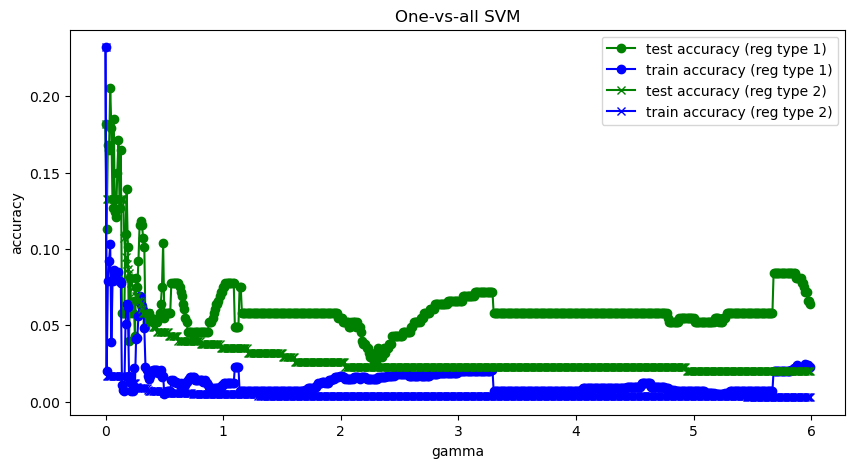

best test accuracy: 0.737      training accuracy: 0.724      norm: 1          gamma: 0.54      


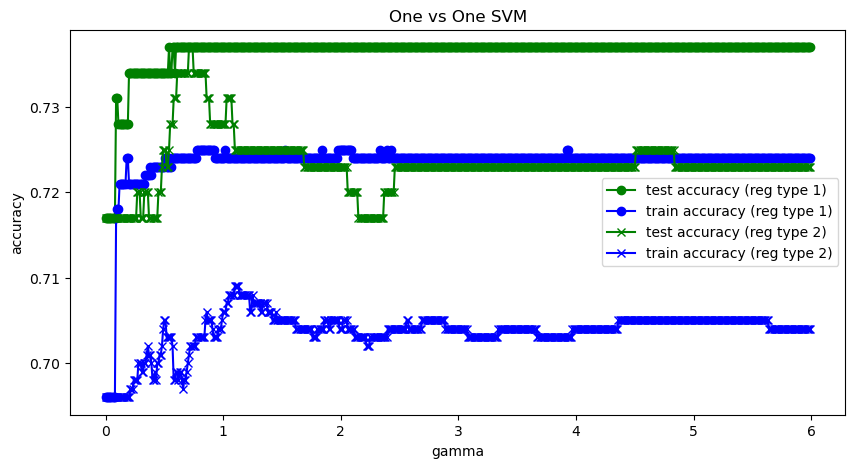

In [66]:
gamma_list = np.arange(0,6,0.01)
train_best_simple_svm(gama_list=gamma_list)

train_best_ova_svm(gamma_list=gamma_list)

train_best_ovo_svm(gamma_list=gamma_list)

In [67]:
train_kernel_svm(train_X, train_y, test_X, test_y, kernel = 'gaussian')

train_kernel_svm(train_X, train_y, test_X, test_y, kernel= 'linear')

train_kernel_svm(train_X, train_y, test_X, test_y, kernel= 'polynomial')

train_kernel_svm(train_X, train_y, test_X, test_y, kernel= 'laplacian')

problem status:  optimal
Kernel: gaussian, Accuracy: 0.8477842003853564
problem status:  optimal
Kernel: linear, Accuracy: 0.6146435452793835
problem status:  optimal
Kernel: polynomial, Accuracy: 0.8227360308285164
problem status:  optimal
Kernel: laplacian, Accuracy: 0.7938342967244701


# Results and Discussion

The results indicate that the Support Vector Machine (SVM) model with a Gaussian kernel achieved the highest accuracy. 

The simple linear SVM demonstrated a good training accuracy. This could be attributed to the fact that it consolidates three classes together, thereby reducing the complexity of the data.

The one-vs-all strategy, on the other hand, yielded the lowest accuracy. Its test accuracy is higher than the training accuracy. This suggests that the model did not learn anything from this strategy, possibly due to the dataset not being linearly separable between one group and the rest. 

The one-vs-one strategy performed relatively well, likely because it considers only two groups at a time, which may be linearly separable.

These results are predicated on the assumption that the data is linearly separable and that the selected kernels and strategies are appropriate for the data. Altering these assumptions could lead to different outcomes. Therefore, further investigation is warranted to optimize the parameters and enhance the performance of the model.

# Project Summary and Future Directions

In this project, we trained and evaluated various types of **Support Vector Machine (SVM)** classification models for a multi-class classification problem using the **Car Evaluation dataset**. We experimented with four different kernel functions: Gaussian, linear, Laplacian, and polynomial.

## Key Findings

Our results indicated that the SVM classifier with the Gaussian kernel function outperformed the other models. The Gaussian kernel's ability to map inputs into a high-dimensional or even infinite-dimensional space enabled it to capture complex nonlinear relationships in the data. This feature makes it particularly effective for handling intricate decision boundaries or non-linear data distributions.

In addition to the Gaussian kernel, the SVM classifiers with the Laplacian and polynomial kernel functions also demonstrated commendable performance. The polynomial kernel's performance improved with higher degrees, but it plateaued after the 7th degree. Conversely, the linear kernel function underperformed, as it is limited to linear classification problems.

## Future Research

For future research, we propose exploring advanced ensemble techniques, such as stacking or boosting, in conjunction with different SVM models and kernel functions. These techniques hold the potential to further enhance the classification performance of the ensemble classifier. By optimizing the combination of models within the ensemble and determining the optimal weightings for their predictions, we can enhance the accuracy and robustness of the classifier. This research could yield valuable insights into the synergies between SVM models and kernel functions, leading to improved results for the multi-class car evaluation problem.